# FGSM ile Adversarial Saldırılar
MNIST veri seti üzerinde eğitilmiş bir sinir ağına yapılan FGSM (Fast Gradient Sign Method) saldırılarını göstermektedir.
İçeriğinde modelin eğitimi, adversarial örneklerin oluşturulması ve sonuçların karşılaştırılması yer almaktadır.

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras import Input

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [22]:
model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8698 - loss: 0.4550 - val_accuracy: 0.9632 - val_loss: 0.1286
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9629 - loss: 0.1265 - val_accuracy: 0.9732 - val_loss: 0.0970
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9757 - loss: 0.0809 - val_accuracy: 0.9747 - val_loss: 0.0907
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9807 - loss: 0.0601 - val_accuracy: 0.9778 - val_loss: 0.0765
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9860 - loss: 0.0449 - val_accuracy: 0.9770 - val_loss: 0.0815


In [25]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test doğruluğu:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.9732 - loss: 0.0863
Test doğruluğu: 0.9760000109672546


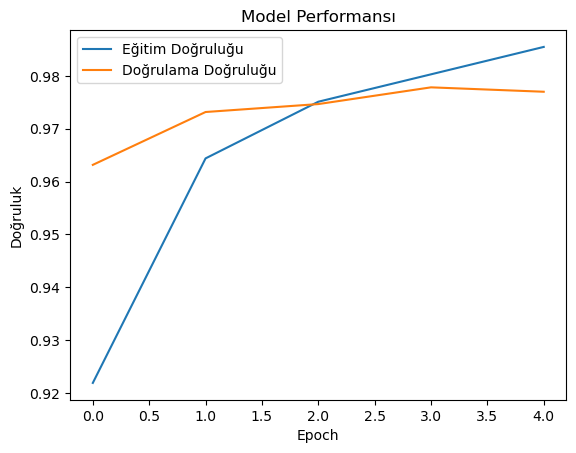

In [26]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Model Performansı')
plt.show()

## FGSM ile Adversarial Saldırı

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def create_adversarial_pattern(model, image, label):
    image = tf.convert_to_tensor(image)
    label = tf.convert_to_tensor([label])  

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad


##  FGSM ile Adversarial Saldırı

In [29]:
# Rastgele bir test görüntüsü seçiyoruz
index = 0  
image = x_test[index]
label = y_test[index]

# Şekli modelin beklediği formata getirdik
image_input = tf.convert_to_tensor(image.reshape((1, 28, 28)))


In [30]:
perturbation = create_adversarial_pattern(model, image_input, label)

In [31]:
epsilon = 0.1  # Ne kadar bozalım?
adv_image = image_input + epsilon * perturbation
adv_image = tf.clip_by_value(adv_image, 0, 1)  # Piksel değerleri 0-1 arasında kalmalı


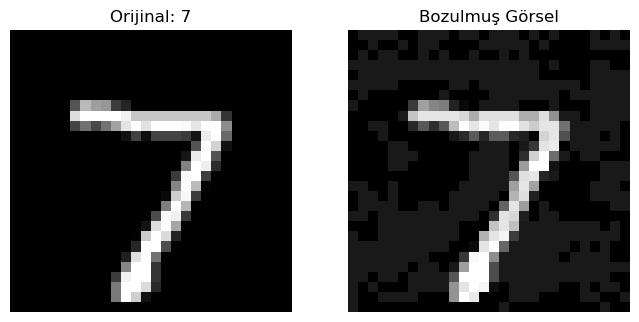

In [33]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title(f"Orijinal: {label}")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Bozulmuş Görsel")
plt.imshow(adv_image.numpy().squeeze(), cmap='gray')
plt.axis('off')

plt.show()


In [34]:
original_pred = tf.argmax(model(image_input), axis=1)
adversarial_pred = tf.argmax(model(adv_image), axis=1)

print("Modelin orijinal tahmini:", original_pred.numpy())
print("Modelin adversarial tahmini:", adversarial_pred.numpy())


Modelin orijinal tahmini: [7]
Modelin adversarial tahmini: [3]


## Adversarial Training ile Modelin Savunmaya Alınması

In [35]:
def generate_adversarial_batch(model, images, labels, epsilon=0.1):
    adv_images = []
    for i in range(len(images)):
        image = tf.convert_to_tensor(images[i].reshape((1, 28, 28)))
        label = tf.convert_to_tensor([labels[i]])
        perturbation = create_adversarial_pattern(model, image, label)
        adv_image = image + epsilon * perturbation
        adv_image = tf.clip_by_value(adv_image, 0, 1)
        adv_images.append(adv_image.numpy().reshape((28, 28)))
    return np.array(adv_images)


In [36]:
# Eğitim verisinden küçük bir örnek al
x_small = x_train[:5000]
y_small = y_train[:5000]

# Adversarial versiyonlarını üret
x_adv = generate_adversarial_batch(model, x_small, y_small, epsilon=0.1)

# Normal + Adversarial verileri birleştir
x_combined = np.concatenate([x_small, x_adv])
y_combined = np.concatenate([y_small, y_small])  # Etiketler aynı kalır

# Yeni bir model oluştur
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input

robust_model = Sequential([
    Input(shape=(28, 28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

robust_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Eğit
robust_model.fit(x_combined, y_combined, epochs=5, validation_split=0.1)


Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7589 - loss: 0.8991 - val_accuracy: 0.9680 - val_loss: 0.1262
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9466 - loss: 0.1914 - val_accuracy: 0.9860 - val_loss: 0.0528
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9704 - loss: 0.1178 - val_accuracy: 0.9940 - val_loss: 0.0317
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9772 - loss: 0.0883 - val_accuracy: 0.9960 - val_loss: 0.0207
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9858 - loss: 0.0603 - val_accuracy: 0.9970 - val_loss: 0.0159


## Savunma Modelinin Dayanıklılık Testi

In [37]:
index = 12  # Rastgele bir test verisi seç
image = x_test[index]
label = y_test[index]

image_input = tf.convert_to_tensor(image.reshape((1, 28, 28)))
label_input = tf.convert_to_tensor([label])


In [38]:
perturbation = create_adversarial_pattern(model, image_input, label_input)
epsilon = 0.1
adv_image = image_input + epsilon * perturbation
adv_image = tf.clip_by_value(adv_image, 0, 1)


In [39]:
old_pred = tf.argmax(model(adv_image), axis=1).numpy()[0]
new_pred = tf.argmax(robust_model(adv_image), axis=1).numpy()[0]


In [40]:
print(f"Gerçek Etiket       : {label}")
print(f"Eski Model Tahmini  : {old_pred}")
print(f"Yeni Model Tahmini  : {new_pred}")


Gerçek Etiket       : 9
Eski Model Tahmini  : 4
Yeni Model Tahmini  : 9
